<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/soil-texture-classification?scriptVersionId=183877244" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center><i>Soil texture classification - USDA</i></center>
---
**Usando la dataset de soil grids**

In [1]:
!pip install -q geemap
!pip install -q geedim

In [2]:
import geemap.foliumap as geemap
import geemap.colormaps as cmap
import geopandas as gpd
import ipywidgets as widgets
import ee

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1ATx3LY7Sg-I-_CR-JUFw6WbpWwkTvU92nqfZx6-gxz_6ZYmnVHsWXSKcU6E



Successfully saved authorization token.


In [4]:
######################################## FUNCIONES APLICADAS EN EL NOTEBOOK ##########################################

def soil_process(image):
    type_soil = ["sand", "silt", "clay"]
    name = image.args["id"]
    for ts in type_soil:
        if ts in name:
            new_image = image.expression('(g1*5 + g2*10 + g3*15)/300',
                                         {
                                             'g1': image.select(f"{ts}_0-5cm_mean"),
                                             'g2': image.select(f"{ts}_5-15cm_mean"),
                                             'g3': image.select(f"{ts}_15-30cm_mean"),
                                         })            

    return new_image

def params_conf(image, geometry):
    min_ = list(image.reduceRegion(ee.Reducer.min(), geometry = geometry).getInfo().values())[0]
    max_ = list(image.reduceRegion(ee.Reducer.max(), geometry = geometry).getInfo().values())[0]
    return (min_, max_)

In [5]:
clay = ee.Image("projects/soilgrids-isric/clay_mean")

sand = ee.Image("projects/soilgrids-isric/sand_mean")

silt = ee.Image("projects/soilgrids-isric/silt_mean")


clay_process = soil_process(clay)

sand_process = soil_process(sand)

silt_process = soil_process(silt)

In [6]:
suhs = ee.FeatureCollection("users/jorgeluiscruzquispe7/SubUnidadesHidrograficas")

suhs_gdf = geemap.ee_to_gdf(suhs)

dropdown = widgets.Dropdown(options = suhs_gdf['Nombre_UH'].tolist(), 
                            value = "Cuenca Gorgor", 
                            description = 'Selecciona un valor: ')

dropdown

Dropdown(description='Selecciona un valor: ', index=47, options=('Cuenca Unidad Hidrografica 131536', 'Cuenca …

In [7]:
basin = ee.FeatureCollection("users/jorgeluiscruzquispe7/SubUnidadesHidrograficas").filter(ee.Filter.eq("Nombre_UH", dropdown.value))


sand_test = sand_process.clip(basin)
silt_test = silt_process.clip(basin)
clay_test = clay_process.clip(basin)

params_sand = {"palette": cmap.palettes.jet, 
               "min": params_conf(sand_test, basin)[0], 
               "max": params_conf(sand_test, basin)[1]}

params_silt = {"palette": cmap.palettes.jet, 
               "min": params_conf(silt_test, basin)[0], 
               "max": params_conf(silt_test, basin)[1]}

params_clay = {"palette": cmap.palettes.jet, 
               "min": params_conf(clay_test, basin)[0], 
               "max": params_conf(clay_test, basin)[1]}

Map = geemap.Map()

Map.centerObject(basin)

Map.add_basemap("HYBRID")

Map.addLayer(sand_test, params_sand, "layer sand")
Map.addLayer(silt_test, params_silt, "layer silt")
Map.addLayer(clay_test, params_clay, "layer clay")

Map.add_gdf(geemap.ee_to_gdf(basin), style = {"color": "red", "fillOpacity": 0}, layer_name = "Subcuenca")

# Map.add_colorbar(params_sand, label = "sand", background_color = "white")
# Map.add_colorbar(params_silt, label = "silt", background_color = "white")
# Map.add_colorbar(params_clay, label = "clay", background_color = "white")

Map

In [8]:
geemap.download_ee_image(sand_test, "sand_sub_basin.tif", region = basin.geometry(), scale = 90, crs = "EPSG:32718")
geemap.download_ee_image(silt_test, "silt_sub_basin.tif", region = basin.geometry(), scale = 90, crs = "EPSG:32718")
geemap.download_ee_image(clay_test, "clay_sub_basin.tif", region = basin.geometry(), scale = 90, crs = "EPSG:32718")

sand_sub_basin.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


silt_sub_basin.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:     ?)

clay_sub_basin.tif: |          | 0.00/453k (raw) [  0.0%] in 00:00 (eta:     ?)

Se continua en SAGA...

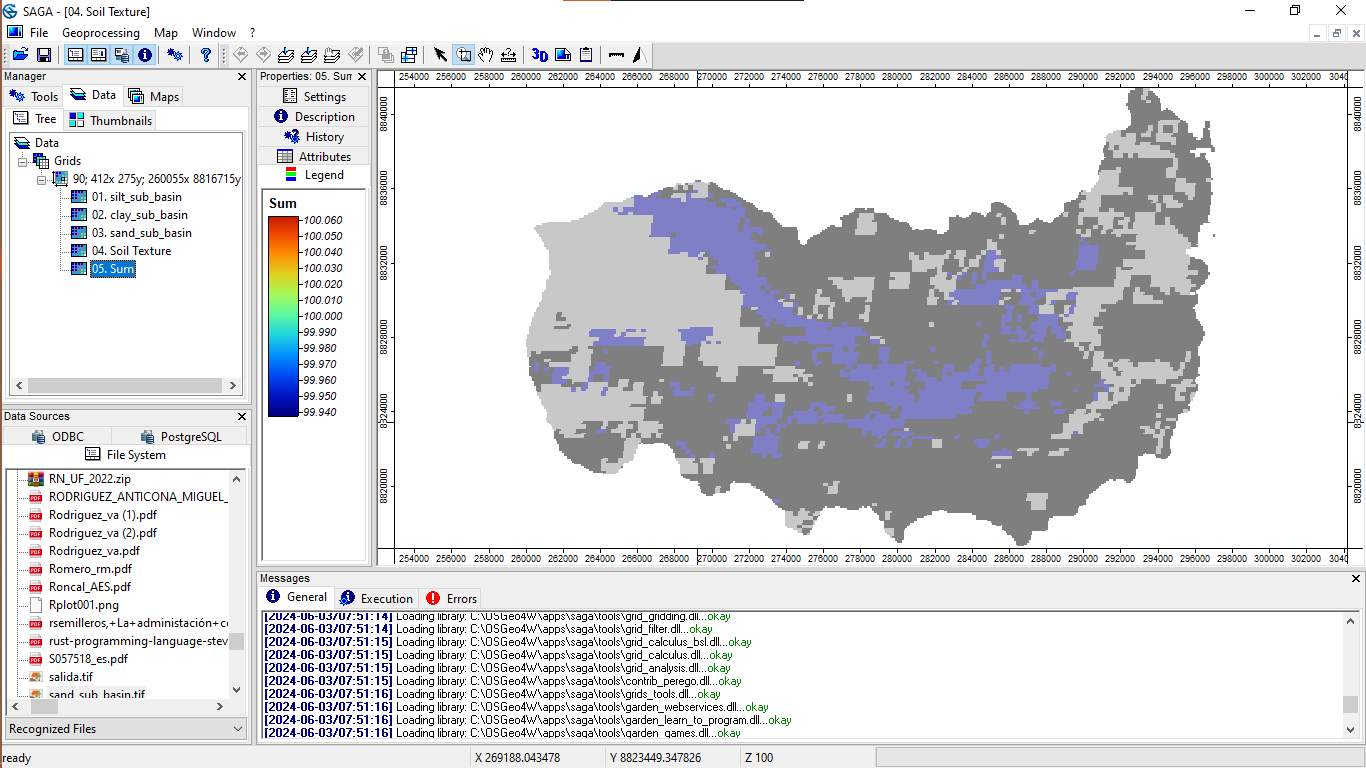